In [1]:
!pip install IPython
from IPython.display import Image

In [ ]:
# !git clone https://github.com/Jiyoon52/LG_time_series_day02_dataset.git # colab 사용시

In [ ]:
# Image('image/image_1.JPG') # 로컬 사용시
Image('/content/LG_time_series_day02_dataset/image/image_1.JPG') # colab 사용시

# [Recurrent Neural Networks - 회귀] 

##### jupyter notebook 단축키

- ctrl+enter: 셀 실행   
- shift+enter: 셀 실행 및 다음 셀 이동   
- alt+enter: 셀 실행, 다음 셀 이동, 새로운 셀 생성
- a: 상단에 새로운 셀 만들기
- b: 하단에 새로운 셀 만들기
- dd: 셀 삭제(x: 셀 삭제)

### 1. 모듈 불러오기

In [178]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import time
import copy

import random

import matplotlib.pyplot as plt     

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def mean_absolute_percentage_error(y_true, y_pred):
    mape = np.mean(np.abs((y_true - y_pred)/y_true))*100
    return mape


from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings(action='ignore') 

### 2. 데이터 불러오기

In [179]:
random_seed = 2022
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [180]:
# co2_data = pd.read_csv('data/co2.csv')
# co2_data = pd.read_csv('/content/LG_time_series_day02_dataset/data/co2.csv')
data = pd.read_csv('./data/reg_nasdaq100.csv')

#### 2.1 Data Exploratory Data Analysis

In [181]:
x = data.drop(['NDX'], axis=1)
y = data[['NDX']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=False)

print(f'x_train shape is {x_train.shape}')
print(f'y_train shape is {y_train.shape}')
print('-'*35)
print(f'x_test shape is {x_test.shape}')
print(f'y_test shape is {y_test.shape}')
print('-'*35)
print('x_train examples')
x_train.head()

x_train shape is (28392, 81)
y_train shape is (28392, 1)
-----------------------------------
x_test shape is (12168, 81)
y_test shape is (12168, 1)
-----------------------------------
x_train examples


,AAL,AAPL,ADBE,ADI,ADP,ADSK,AKAM,ALXN,AMAT,AMGN,...,TSLA,TXN,VIAB,VOD,VRTX,WBA,WDC,WFM,XLNX,YHOO
0,35.9800,96.80,97.80,61.15,95.4000,58.180000,58.00,127.040,26.680,165.8100,...,227.6500,70.73,45.230,31.1701,95.270,81.365,52.16,33.95,48.61,38.010
1,35.9310,96.89,97.80,61.61,95.4115,58.190000,58.12,126.060,26.730,165.9101,...,227.0967,70.69,45.010,31.1900,94.170,81.540,52.15,34.10,48.74,38.140
2,35.9044,96.95,97.57,61.98,95.5100,58.203333,57.95,126.510,26.712,166.1800,...,226.6300,71.30,45.015,31.2100,94.749,81.530,52.27,34.01,48.99,38.150
3,35.8900,96.97,97.55,62.09,95.5200,58.216667,57.96,126.280,26.740,166.1480,...,227.5300,71.31,45.020,31.2100,94.310,81.710,52.30,33.96,48.95,38.195
4,36.0080,96.96,97.73,61.89,95.5300,58.230000,58.21,126.585,26.720,165.9900,...,227.1250,71.06,45.050,31.1800,94.155,81.720,52.30,34.17,48.89,38.320


In [182]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

columns_list = list(x_train.columns)
x_train = x_scaler.fit_transform(x_train)
x_test = x_scaler.transform(x_test)
y_train = y_scaler.fit_transform(y_train)
y_test = y_scaler.transform(y_test)

y_train = y_train.squeeze()
y_test = y_test.squeeze()

print('x_train examples')
pd.DataFrame(x_train, columns = columns_list).head()

x_train examples


,AAL,AAPL,ADBE,ADI,ADP,ADSK,AKAM,ALXN,AMAT,AMGN,...,TSLA,TXN,VIAB,VOD,VRTX,WBA,WDC,WFM,XLNX,YHOO
0,0.377892,0.016446,0.150063,0.277457,0.944656,0.083294,0.442140,0.361793,0.185741,0.740166,...,0.823137,0.702265,0.916632,0.887439,0.719682,0.568587,0.482152,0.914599,0.012559,0.000000
1,0.371594,0.020501,0.150063,0.343931,0.945754,0.083897,0.447342,0.326930,0.195122,0.742574,...,0.812146,0.695793,0.898382,0.891832,0.683234,0.589075,0.481620,0.936496,0.032967,0.018868
2,0.368175,0.023205,0.135313,0.397399,0.955153,0.084701,0.439973,0.342938,0.191745,0.749068,...,0.802876,0.794498,0.898797,0.896247,0.702419,0.587904,0.488013,0.923358,0.072214,0.020319
3,0.366324,0.024106,0.134030,0.413295,0.956107,0.085505,0.440406,0.334756,0.196998,0.748298,...,0.820753,0.796117,0.899212,0.896247,0.687873,0.608977,0.489611,0.916058,0.065934,0.026851
4,0.381491,0.023656,0.145573,0.384393,0.957061,0.086309,0.451243,0.345607,0.193246,0.744497,...,0.812709,0.755663,0.901701,0.889625,0.682737,0.610148,0.489611,0.946715,0.056515,0.044993


#### 2.2 Data Windowing

In [183]:
def windowing_process(x, y, window_size, shift_size, last = True):
    try:
        x = x.reset_index(drop=True)
        y = y.reset_index(drop=True)
    except:
        pass
    
    x_window = []
    y_window = []
    
    for start_idx in range(0, x.shape[0] - window_size + 1, shift_size):
        x_window.append(x[start_idx:start_idx + window_size])
        
        if last == True:
            y_window.append(y[start_idx + window_size - 1])
        
        else:
            y_window.append(np.mean(y[start_idx:start_idx + window_size]))
    
    x_window = np.array(x_window)
    y_window = np.array(y_window)
    
    return x_window, y_window

In [184]:
x_train, y_train = windowing_process(x_train, y_train, 5, 1, True)
x_test, y_test = windowing_process(x_test, y_test, 5, 1, True)

print(f'x_train shape is {x_train.shape}')
print(f'y_train shape is {y_train.shape}')
print('-'*35)
print(f'x_test shape is {x_test.shape}')
print(f'y_test shape is {y_test.shape}')

x_train shape is (28388, 5, 81)
y_train shape is (28388,)
-----------------------------------
x_test shape is (12164, 5, 81)
y_test shape is (12164,)


In [185]:
n_train = int(0.8 * len(x_train))
x_valid, y_valid = x_train[n_train:], y_train[n_train:]
x_train, y_train = x_train[:n_train], y_train[:n_train]

print(f'x_train shape is {x_train.shape}')
print(f'y_train shape is {y_train.shape}')
print('-'*35)
print(f'x_train shape is {x_valid.shape}')
print(f'y_train shape is {y_valid.shape}')
print('-'*35)
print(f'x_test shape is {x_test.shape}')
print(f'y_test shape is {y_test.shape}')

x_train shape is (22710, 5, 81)
y_train shape is (22710,)
-----------------------------------
x_train shape is (5678, 5, 81)
y_train shape is (5678,)
-----------------------------------
x_test shape is (12164, 5, 81)
y_test shape is (12164,)


### 3. RNN Modeling (RNN, LSTM, GRU)

#### 3.1 Define the Model Structure

In [186]:
class RNN_model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bidirectional, rnn_type, device='cuda'):
        super(RNN_model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn_type = rnn_type
        self.num_directions = 2 if bidirectional == True else 1
        self.device = device
        
        # rnn_type에 따른 recurrent layer 설정
        if self.rnn_type == 'rnn':
            self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        elif self.rnn_type == 'lstm':
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        elif self.rnn_type == 'gru':
            self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        
        # bidirectional에 따른 fc layer 구축
        # bidirectional 여부에 따라 hidden state의 shape가 달라짐 (True: 2 * hidden_size, False: hidden_size)
        self.fc = nn.Linear(self.num_directions * hidden_size, 1)

    def forward(self, x):
        # data dimension: (batch_size x input_size x seq_len) -> (batch_size x seq_len x input_size)로 변환
        # x = torch.transpose(x, 1, 2)
        
        # initial hidden states 설정
        h0 = torch.zeros(self.num_directions * self.num_layers, x.size(0), self.hidden_size).to(self.device)
        
        # 선택한 rnn_type의 RNN으로부터 output 도출
        if self.rnn_type in ['rnn', 'gru']:
            out, _ = self.rnn(x, h0)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        else:
            # initial cell states 설정
            c0 = torch.zeros(self.num_directions * self.num_layers, x.size(0), self.hidden_size).to(self.device)
            out, _ = self.rnn(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        out = self.fc(out[:, -1, :])
        return out

#### 3.2 Define The Training Testing Strategy

In [187]:
class Train_Test():
    def __init__(self,  train_loader, valid_loader, test_loader, input_size, device='cuda'): 
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.test_loader = test_loader

        self.input_size = input_size

    def train(self, model, dataloaders, criterion, num_epochs, optimizer):
        since = time.time() 
        
        train_loss_history = []
        val_loss_history = []

        best_model_wts = copy.deepcopy(model.state_dict()) # 모델의 초기 Weight값 (각 Layer 별 초기 Weight값이 저장되어 있음)
        best_loss = 999999999

        for epoch in range(num_epochs):
            if epoch == 0 or (epoch + 1) % 10 == 0:
                print()
                print('Epoch {}/{}'.format(epoch + 1, num_epochs))

            # 각 epoch마다 순서대로 training과 validation을 진행
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # 모델을 training mode로 설정
                else:
                    model.eval()   # 모델을 validation mode로 설정

                running_loss = 0.0
                running_total = 0

                # training과 validation 단계에 맞는 dataloader에 대하여 학습/검증 진행
                for inputs, targets in dataloaders[phase]:
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    # seq_lens = seq_lens.to(self.parameter['device'])
                    
                    # parameter gradients를 0으로 설정
                    optimizer.zero_grad()

                    # forward
                    # training 단계에서만 gradient 업데이트 수행
                    with torch.set_grad_enabled(phase == 'train'):

                        # input을 model에 넣어 output을 도출한 후, loss를 계산함
                        outputs = model(inputs)
                        outputs = outputs.reshape(-1)
                        
                        loss = criterion(outputs, targets)

                        # backward (optimize): training 단계에서만 수행
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # batch별 loss를 축적함
                    running_loss += loss.item() * inputs.size(0)
                    running_total += targets.size(0)

                # epoch의 loss 및 accuracy 도출
                epoch_loss = running_loss / running_total
                                    
                if epoch == 0 or (epoch + 1) % 10 == 0:
                    print('{} Loss: {:.4f}'.format(phase, epoch_loss))

                # validation 단계에서 validation loss가 감소할 때마다 best model 가중치를 업데이트함
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                if phase == 'train':
                    train_loss_history.append(epoch_loss)
                elif phase == 'val':
                    val_loss_history.append(epoch_loss)

        # 전체 학습 시간 계산 (학습이 완료된 후)
        time_elapsed = time.time() - since
        print('\nTraining complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best val MSE: {:4f}'.format(best_loss))

        # validation loss가 가장 낮았을 때의 best model 가중치를 불러와 best model을 구축함
        model.load_state_dict(best_model_wts)
        return model, train_loss_history, val_loss_history

    def test(self, model, test_loader):
        model.eval()   # 모델을 validation mode로 설정
        
        # test_loader에 대하여 검증 진행 (gradient update 방지)
        with torch.no_grad():

            preds = []
            y_true = []
            for inputs, targets in test_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                # forward
                # input을 model에 넣어 output을 도출
                pred = model(inputs)
                
                preds.extend(pred.detach().cpu().numpy())
                y_true.extend(targets.detach().cpu().numpy())

            preds = torch.tensor(preds).reshape(-1)
            y_true = torch.tensor(y_true)
            
            mse = nn.MSELoss()(preds, y_true).item()
            preds = preds.detach().cpu().numpy()
        return preds, mse

### 4. Model Training

#### RNN

#### 4.1 Hyperparameter Setting

In [188]:
batch_size = 128
input_size = x_train.shape[2]
hidden_size = 64
num_layers = 2
bidirectional = True
num_epochs = 200
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu') 
rnn_type='rnn'
rnn_best_model_path = f'./ckpt/{rnn_type}_reg.pt'

#### 4.2 Construct Data Loaders and Model

In [189]:
datasets = []
for dataset in [(x_train, y_train), (x_valid, y_valid), (x_test, y_test)]:
    x_data = dataset[0]
    y_data = dataset[1]
    datasets.append(torch.utils.data.TensorDataset(torch.Tensor(x_data), torch.Tensor(y_data)))

trainset, validset, testset = datasets[0], datasets[1], datasets[2]
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

dataloaders_dict = {'train': train_loader, 'val': valid_loader}

In [190]:
rnn_model = RNN_model(input_size, hidden_size, num_layers, bidirectional, rnn_type, device)
rnn_model = rnn_model.to(device)

In [191]:
rnn_model

RNN_model(
  (rnn): RNN(81, 64, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [192]:
rnn_trainer = Train_Test(train_loader, valid_loader, test_loader, input_size, device)

#### 4.3 Model Training and Save Weights(Parameters)

#### LSTM

#### 4.1 Hyperparameter Setting

In [81]:
batch_size = 128
input_size = x_train.shape[2]
hidden_size = 64
num_layers = 2
bidirectional = True
num_epochs = 200
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu') 
rnn_type='lstm'
lstm_best_model_path = f'./ckpt/{rnn_type}_reg.pt'

#### 4.2 Construct Data Loaders and Model

In [38]:
lstm_model = RNN_model(input_size, hidden_size, num_layers, bidirectional, rnn_type, device)
lstm_model = lstm_model.to(device)

In [39]:
lstm_model

RNN_model(
  (rnn): LSTM(81, 64, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [30]:
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.0001)

#### 4.3 Model Training and Save Weights(Parameters)

In [31]:
lstm_trainer = Train_Test(train_loader, valid_loader, test_loader, input_size, device)
lstm_best_model, lstm_train_loss_history, lstm_val_loss_history = lstm_trainer.train(lstm_model, dataloaders_dict, criterion, num_epochs, optimizer)


Epoch 1/200
train Loss: 0.0857
val Loss: 0.0287

Epoch 10/200
train Loss: 0.0002
val Loss: 0.0177

Epoch 20/200
train Loss: 0.0001
val Loss: 0.0151

Epoch 30/200
train Loss: 0.0001
val Loss: 0.0138

Epoch 40/200
train Loss: 0.0000
val Loss: 0.0127

Epoch 50/200
train Loss: 0.0000
val Loss: 0.0120

Epoch 60/200
train Loss: 0.0000
val Loss: 0.0112

Epoch 70/200
train Loss: 0.0000
val Loss: 0.0108

Epoch 80/200
train Loss: 0.0000
val Loss: 0.0098

Epoch 90/200
train Loss: 0.0000
val Loss: 0.0091

Epoch 100/200
train Loss: 0.0000
val Loss: 0.0086

Epoch 110/200
train Loss: 0.0000
val Loss: 0.0081

Epoch 120/200
train Loss: 0.0000
val Loss: 0.0079

Epoch 130/200
train Loss: 0.0000
val Loss: 0.0073

Epoch 140/200
train Loss: 0.0000
val Loss: 0.0067

Epoch 150/200
train Loss: 0.0000
val Loss: 0.0064

Epoch 160/200
train Loss: 0.0000
val Loss: 0.0061

Epoch 170/200
train Loss: 0.0000
val Loss: 0.0058

Epoch 180/200
train Loss: 0.0000
val Loss: 0.0054

Epoch 190/200
train Loss: 0.0000
val Loss

Text(0, 0.5, 'loss')

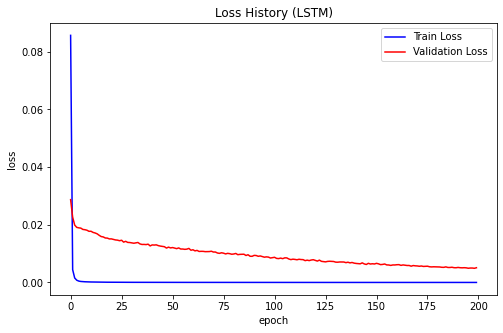

In [40]:
plt.figure(figsize=(8,5))
plt.title('Loss History (LSTM)')
plt.plot(range(num_epochs), lstm_train_loss_history, c='blue', label='Train Loss')
plt.plot(range(num_epochs), lstm_val_loss_history, c='red', label='Validation Loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

In [41]:
torch.save(lstm_best_model.state_dict(), lstm_best_model_path)

#### GRU

#### 4.1 Hyperparameter Setting

In [42]:
batch_size = 128
input_size = x_train.shape[2]
hidden_size = 64
num_layers = 2
bidirectional = True
num_epochs = 200
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu') 
rnn_type='gru'
gru_best_model_path = f'./ckpt/{rnn_type}_reg.pt'

#### 4.2 Construct Data Loaders and Model

In [43]:
gru_model = RNN_model(input_size, hidden_size, num_layers, bidirectional, rnn_type, device)
gru_model = gru_model.to(device)

In [44]:
gru_model

RNN_model(
  (rnn): GRU(81, 64, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [45]:
criterion = nn.MSELoss()
optimizer = optim.Adam(gru_model.parameters(), lr=0.0001)

#### 4.3 Model Training and Save Weights(Parameters)

In [46]:
gru_trainer = Train_Test(train_loader, valid_loader, test_loader, input_size, device)
gru_best_model, gru_train_loss_history, gru_val_loss_history = gru_trainer.train(gru_model, dataloaders_dict, criterion, num_epochs, optimizer)


Epoch 1/200
train Loss: 0.0635
val Loss: 0.0259

Epoch 10/200
train Loss: 0.0002
val Loss: 0.0347

Epoch 20/200
train Loss: 0.0001
val Loss: 0.0263

Epoch 30/200
train Loss: 0.0001
val Loss: 0.0224

Epoch 40/200
train Loss: 0.0000
val Loss: 0.0173

Epoch 50/200
train Loss: 0.0000
val Loss: 0.0128

Epoch 60/200
train Loss: 0.0000
val Loss: 0.0089

Epoch 70/200
train Loss: 0.0000
val Loss: 0.0065

Epoch 80/200
train Loss: 0.0000
val Loss: 0.0045

Epoch 90/200
train Loss: 0.0000
val Loss: 0.0036

Epoch 100/200
train Loss: 0.0000
val Loss: 0.0029

Epoch 110/200
train Loss: 0.0000
val Loss: 0.0025

Epoch 120/200
train Loss: 0.0000
val Loss: 0.0022

Epoch 130/200
train Loss: 0.0000
val Loss: 0.0019

Epoch 140/200
train Loss: 0.0000
val Loss: 0.0017

Epoch 150/200
train Loss: 0.0000
val Loss: 0.0016

Epoch 160/200
train Loss: 0.0000
val Loss: 0.0014

Epoch 170/200
train Loss: 0.0000
val Loss: 0.0014

Epoch 180/200
train Loss: 0.0000
val Loss: 0.0013

Epoch 190/200
train Loss: 0.0000
val Loss

Text(0, 0.5, 'loss')

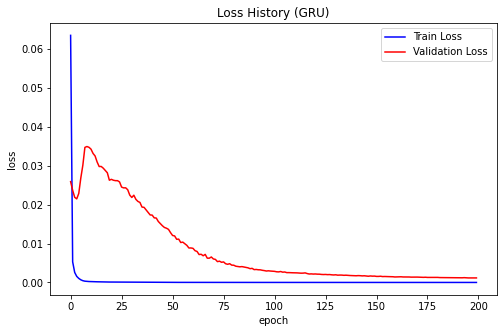

In [47]:
plt.figure(figsize=(8,5))
plt.title('Loss History (GRU)')
plt.plot(range(num_epochs), gru_train_loss_history, c='blue', label='Train Loss')
plt.plot(range(num_epochs), gru_val_loss_history, c='red', label='Validation Loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

In [48]:
torch.save(gru_best_model.state_dict(), gru_best_model_path)

### 5. Attention Mechanism

#### 5.1 Define the Model Structure

In [63]:
class Attention(nn.Module):
    def __init__(self, hidden_size, device):
        super(Attention, self).__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.concat_linear = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size, self.hidden_size)

    def forward(self, rnn_outputs, final_hidden_state):
        # rnn_output.shape:         (batch_size, seq_len, hidden_size)
        # final_hidden_state.shape: (batch_size, hidden_size)
        
        batch_size, seq_len, _ = rnn_outputs.shape
        
        attn_value = self.attn(rnn_outputs) # (batch_size, seq_len, hidden_dim)
        final_hidden_state = final_hidden_state.unsqueeze(2) # (batch_size, hidden_dim, 1)
        attn_value = torch.bmm(attn_value, final_hidden_state) # (batch_size, seq_len, 1)
        attn_probability = F.softmax(attn_value.squeeze(2), dim=1) # (batch_size, seq_len)

        context = torch.bmm(rnn_outputs.transpose(1, 2), attn_probability.unsqueeze(2)).squeeze(2)
                 # (batch_size, hidden_size, seq_len) X (batch_size, seq_len, 1) = (batch_size, hidden_size)
        attn_hidden = torch.tanh(self.concat_linear(torch.cat((context, final_hidden_state.squeeze(2)), dim=1)))
        # attn_hidden = torch.tanh(context)
        return attn_hidden, attn_probability

In [64]:
class RNN_Attention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, bidirectional, rnn_type, device='cuda'):
        super(RNN_Attention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_directions = 2 if bidirectional == True else 1
        self.rnn_type = rnn_type
        self.num_classes = num_classes
        
        # rnn_type에 따른 recurrent layer 설정
        if self.rnn_type == 'rnn':
            self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        elif self.rnn_type == 'lstm':
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        elif self.rnn_type == 'gru':
            self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        self.attn = Attention(hidden_size * self.num_directions, device)
        self.fc = nn.Linear(hidden_size * self.num_directions, num_classes)

    def forward(self, x):
        batch_size, _, seq_len = x.shape
        
        # data dimension: (batch_size x input_size x seq_len) -> (batch_size x seq_len x input_size)로 변환
        # x = torch.transpose(x, 1, 2)
        
        # initial hidden states 설정
        h0 = torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_size).to(device)
        
        # 선택한 rnn_type의 RNN으로부터 output 도출
        if self.rnn_type in ['rnn', 'gru']:
            out, hidden = self.rnn(x, h0)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        else:
            # initial cell states 설정
            c0 = torch.zeros(self.num_directions * self.num_layers, x.size(0), self.hidden_size).to(self.device)
            out, hidden = self.rnn(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        final_state = hidden.view(self.num_layers, self.num_directions, batch_size, self.hidden_size)[-1]
        
        # Handle directions
        final_hidden_state = None
        if self.num_directions == 1:
            final_hidden_state = final_state.squeeze(0)
        elif self.num_directions == 2:
            h_1, h_2 = final_state[0], final_state[1]
            final_hidden_state = torch.cat((h_1, h_2), 1)  # Concatenate both states

        # Push through attention layer
        attn_output, attn_scores = self.attn(out, final_hidden_state)
        attn_output = self.fc(attn_output)
        return attn_output, attn_scores

#### 5.2 Define The Training Testing Strategy

In [111]:
class Train_Test_Attention():
    def __init__(self,  train_loader, valid_loader, test_loader, input_size, num_classes, device='cuda'): ##### config는 jupyter 파일을 참고
        """
        Initialize Train_Test class

        :param config: configuration
        :type config: dictionary

        :param train_loader: train dataloader
        :type config: DataLoader

        :param valid_loader: validation dataloader
        :type config: DataLoader

        :param test_loader: test dataloader
        :type config: DataLoader
        """

        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.test_loader = test_loader

        self.input_size = input_size
        self.num_classes = num_classes

    def train(self, model, dataloaders, criterion, num_epochs, optimizer):
        """
        Train the model

        :param model: initialized model
        :type model: model

        :param dataloaders: train & validation dataloaders
        :type dataloaders: dictionary

        :param criterion: loss function for training
        :type criterion: criterion

        :param num_epochs: the number of train epochs
        :type num_epochs: int

        :param optimizer: optimizer used in training
        :type optimizer: optimizer

        :return: trained model
        :rtype: model
        """

        since = time.time() 
        
        train_loss_history = []
        val_loss_history = []

        best_model_wts = copy.deepcopy(model.state_dict()) # 모델의 초기 Weight값 (각 Layer 별 초기 Weight값이 저장되어 있음)
        best_loss = 999999999

        for epoch in range(num_epochs):
            if epoch == 0 or (epoch + 1) % 10 == 0:
                print()
                print('Epoch {}/{}'.format(epoch + 1, num_epochs))

            # 각 epoch마다 순서대로 training과 validation을 진행
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # 모델을 training mode로 설정
                else:
                    model.eval()   # 모델을 validation mode로 설정

                running_loss = 0.0
                running_total = 0

                # training과 validation 단계에 맞는 dataloader에 대하여 학습/검증 진행
                for inputs, targets in dataloaders[phase]:
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    # seq_lens = seq_lens.to(self.parameter['device'])
                    
                    # parameter gradients를 0으로 설정
                    optimizer.zero_grad()

                    # forward
                    # training 단계에서만 gradient 업데이트 수행
                    with torch.set_grad_enabled(phase == 'train'):

                        # input을 model에 넣어 output을 도출한 후, loss를 계산함
                        outputs, attn_scores = model(inputs)
                        outputs = outputs.reshape(-1)
                        
                        loss = criterion(outputs, targets)

                        # backward (optimize): training 단계에서만 수행
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # batch별 loss를 축적함
                    running_loss += loss.item() * inputs.size(0)
                    running_total += targets.size(0)

                # epoch의 loss 및 accuracy 도출
                epoch_loss = running_loss / running_total
                                    
                if epoch == 0 or (epoch + 1) % 10 == 0:
                    print('{} Loss: {:.4f}'.format(phase, epoch_loss))

                # validation 단계에서 validation loss가 감소할 때마다 best model 가중치를 업데이트함
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                if phase == 'train':
                    train_loss_history.append(epoch_loss)
                elif phase == 'val':
                    val_loss_history.append(epoch_loss)

        # 전체 학습 시간 계산 (학습이 완료된 후)
        time_elapsed = time.time() - since
        print('\nTraining complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best val MSE: {:4f}'.format(best_loss))

        # validation loss가 가장 낮았을 때의 best model 가중치를 불러와 best model을 구축함
        model.load_state_dict(best_model_wts)
        return model, train_loss_history, val_loss_history, attn_scores

    def test(self, model, test_loader):
        """
        Predict classes for test dataset based on the trained model

        :param model: best trained model
        :type model: model

        :param test_loader: test dataloader
        :type test_loader: DataLoader

        :return: predicted classes
        :rtype: numpy array

        :return: prediction probabilities
        :rtype: numpy array

        :return: test accuracy
        :rtype: float
        """

        model.eval()   # 모델을 validation mode로 설정
        
        # test_loader에 대하여 검증 진행 (gradient update 방지)
        with torch.no_grad():

            preds = []
            y_true = []
            attn_scores = []
            for inputs, targets in test_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                # forward
                # input을 model에 넣어 output을 도출
                pred, attn_score = model(inputs)
                
                preds.extend(pred.detach().cpu().numpy())
                y_true.extend(targets.detach().cpu().numpy())
                attn_scores.extend(attn_score.detach().cpu().tolist())
                
            preds = torch.tensor(preds).reshape(-1)
            y_true = torch.tensor(y_true)
            attn_scores = torch.tensor(attn_scores)
            
            mse = nn.MSELoss()(preds, y_true).item()
            preds = preds.detach().cpu().numpy()
            attn_scores = attn_scores.detach().cpu().numpy()
        return preds, mse, attn_scores

#### 5.3 Model Training

In [201]:
batch_size = 128
input_size = x_train.shape[2]
hidden_size = 64
num_layers = 2
bidirectional = True
num_epochs = 500
num_classes = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu') 
rnn_type='rnn'
attn_best_model_path = f'./ckpt/{rnn_type}_with_attn_reg.pt'

In [202]:
attn_model = RNN_Attention(input_size, hidden_size, num_layers, num_classes, bidirectional, rnn_type, device)
attn_model = attn_model.to(device)

In [203]:
attn_model

RNN_Attention(
  (rnn): RNN(81, 64, num_layers=2, batch_first=True, bidirectional=True)
  (attn): Attention(
    (concat_linear): Linear(in_features=256, out_features=128, bias=True)
    (attn): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [204]:
criterion = nn.MSELoss()
optimizer = optim.Adam(attn_model.parameters(), lr=0.0001)

In [205]:
attn_trainer = Train_Test_Attention(train_loader, valid_loader, test_loader, input_size, device)
attn_best_model, attn_train_loss_history, attn_val_loss_history, attn_scores = attn_trainer.train(attn_model, dataloaders_dict, criterion, num_epochs, optimizer)


Epoch 1/500
train Loss: 0.0139
val Loss: 0.0252

Epoch 10/500
train Loss: 0.0001
val Loss: 0.0284

Epoch 20/500
train Loss: 0.0000
val Loss: 0.0287

Epoch 30/500
train Loss: 0.0000
val Loss: 0.0227

Epoch 40/500
train Loss: 0.0000
val Loss: 0.0176

Epoch 50/500
train Loss: 0.0000
val Loss: 0.0130

Epoch 60/500
train Loss: 0.0000
val Loss: 0.0093

Epoch 70/500
train Loss: 0.0000
val Loss: 0.0082

Epoch 80/500
train Loss: 0.0000
val Loss: 0.0063

Epoch 90/500
train Loss: 0.0000
val Loss: 0.0044

Epoch 100/500
train Loss: 0.0000
val Loss: 0.0033

Epoch 110/500
train Loss: 0.0000
val Loss: 0.0032

Epoch 120/500
train Loss: 0.0000
val Loss: 0.0026

Epoch 130/500
train Loss: 0.0000
val Loss: 0.0023

Epoch 140/500
train Loss: 0.0000
val Loss: 0.0022

Epoch 150/500
train Loss: 0.0000
val Loss: 0.0019

Epoch 160/500
train Loss: 0.0000
val Loss: 0.0019

Epoch 170/500
train Loss: 0.0000
val Loss: 0.0018

Epoch 180/500
train Loss: 0.0000
val Loss: 0.0019

Epoch 190/500
train Loss: 0.0000
val Loss

Text(0, 0.5, 'loss')

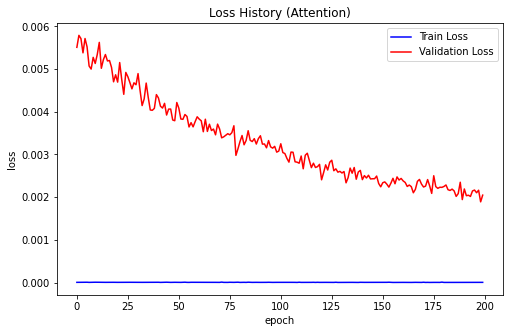

In [72]:
plt.figure(figsize=(8,5))
plt.title('Loss History (Attention)')
plt.plot(range(num_epochs), attn_train_loss_history, c='blue', label='Train Loss')
plt.plot(range(num_epochs), attn_val_loss_history, c='red', label='Validation Loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

In [77]:
torch.save(attn_best_model.state_dict(), attn_best_model_path)

### 6. Model Validation

#### 6.1 Load Model Weights(Parameters)

In [193]:
rnn_model.load_state_dict(torch.load(rnn_best_model_path))
lstm_model.load_state_dict(torch.load(lstm_best_model_path))
gru_model.load_state_dict(torch.load(gru_best_model_path))
attn_model.load_state_dict(torch.load(attn_best_model_path))

<All keys matched successfully>

In [194]:
def regression_report(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred) 
    mse = mean_squared_error(y_true, y_pred) 
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
      
    print('The regression reports are as follows:')
    print('r2: ', round(r2,4))
    print('MAE: ', round(mae,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(rmse,4))
    print('MAPE: ', round(mape,4))
    return r2, mae, mse, rmse, mape

In [195]:
y_test_inverse = y_scaler.inverse_transform(pd.DataFrame(y_test))
y_train_inverse = y_scaler.inverse_transform(pd.DataFrame(y_train))
y_valid_inverse = y_scaler.inverse_transform(pd.DataFrame(y_valid))

In [196]:
name_list = []
r2_list = []
mae_list = []
mse_list = []
rmse_list = []
mape_list = []

results_df = pd.DataFrame()
y_pred_df = pd.DataFrame()
    
for model_set in zip(['rnn', 'lstm', 'gru', 'attn'], 
                      [rnn_model, lstm_model, gru_model, attn_model], 
                      [rnn_trainer, lstm_trainer, gru_trainer, attn_trainer]):
    name = model_set[0]
    model = model_set[1]
    trainer = model_set[2]
    print(name)
    try:
        y_pred, mse = trainer.test(model, test_loader)
    except:
        y_pred, mse, attn_scores = trainer.test(model, test_loader)
        
    y_pred_inverse = y_scaler.inverse_transform(pd.DataFrame(y_pred))   
    r2, mae, mse, rmse, mape = regression_report (y_test_inverse.flatten(), y_pred_inverse.flatten())
    r2_list.append(r2)
    mae_list.append(mae)
    mse_list.append(mse)
    rmse_list.append(rmse)
    mape_list.append(mape)
    name_list.append(name)
    
    y_train_concat = np.concatenate([y_train_inverse, y_valid_inverse], axis=0)
    y_train = np.concatenate([y_train_concat, np.array([np.nan]*len(y_test_inverse)).reshape(len(y_test_inverse), -1)], axis=0)
    y_test = np.concatenate([np.array([np.nan]*len(y_train_concat)).reshape(len(y_train_concat), -1), y_test_inverse], axis=0)
    y_pred = np.concatenate([np.array([np.nan]*len(y_train_concat)).reshape(len(y_train_concat), -1), y_pred_inverse], axis=0)

    y_train = pd.DataFrame(y_train, columns = [f'Train set'])
    y_test = pd.DataFrame(y_test, columns = [f'Test set'])
    y_pred = pd.DataFrame(y_pred, columns = [f'Predictions {name}'])
    y_pred_df = pd.concat([y_pred_df, y_pred], axis=1)
    
results_df['Model'] = name_list
results_df['R2 score'] = r2_list
results_df['MAE'] = mae_list
results_df['MSE'] = mse_list
results_df['RMSE'] = rmse_list
results_df['MAPE'] = mape_list

rnn
The regression reports are as follows:
r2:  0.9419
MAE:  16.6391
MSE:  329.0504
RMSE:  18.1397
MAPE:  0.3444
lstm
The regression reports are as follows:
r2:  0.854
MAE:  22.3828
MSE:  827.3721
RMSE:  28.7641
MAPE:  0.4581
gru
The regression reports are as follows:
r2:  0.6762
MAE:  35.4722
MSE:  1835.0152
RMSE:  42.8371
MAPE:  0.7264
attn
The regression reports are as follows:
r2:  0.2776
MAE:  55.894
MSE:  4093.8973
RMSE:  63.9836
MAPE:  1.1467


In [197]:
results_df

,Model,R2 score,MAE,MSE,RMSE,MAPE
0,rnn,0.941933,16.639131,329.050386,18.139746,0.344363
1,lstm,0.853994,22.382835,827.372146,28.764077,0.458133
2,gru,0.676175,35.472218,1835.015232,42.837078,0.726390
3,attn,0.277551,55.894000,4093.897345,63.983571,1.146739


In [198]:
y_pred_df

,Predictions rnn,Predictions lstm,Predictions gru,Predictions attn
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
...,...,...,...,...
40547,4903.842285,4858.712891,4837.789062,4825.676270
40548,4903.981934,4858.898926,4837.808594,4825.708496
40549,4904.152344,4859.000977,4838.000488,4825.783691
40550,4904.788086,4859.812988,4838.664551,4826.336426


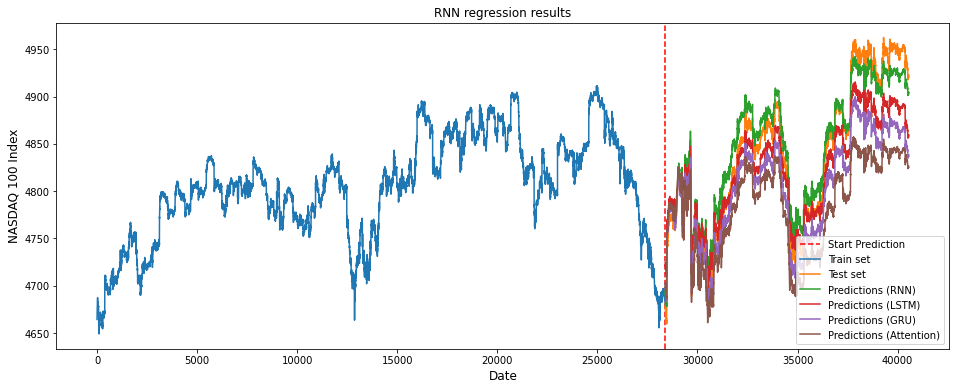

In [200]:
plt.figure(figsize=(16,6))
plt.title('RNN regression results', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.ylabel('NASDAQ 100 Index', fontsize=12)
plt.axvline(x=len(y_train_concat), color='r', label='Start Prediction', ls='--')
plt.plot(y_train['Train set'])
plt.plot(y_test['Test set'])
plt.plot(y_pred_df['Predictions rnn'])
plt.plot(y_pred_df['Predictions lstm'])
plt.plot(y_pred_df['Predictions gru'])
plt.plot(y_pred_df['Predictions attn'])
plt.legend(['Start Prediction', 'Train set', 'Test set', 
            'Predictions (RNN)', 'Predictions (LSTM)',
            'Predictions (GRU)', 'Predictions (Attention)'], loc='lower right')
plt.show()

# EOD